# Modeling to Classify Koi Fish Varieties and Traits

#### Multi-label, multi-class image classification for koi fish varieties and traits. The current dataset includes two varieties: Kohaku, Sanke and Showa, and two traits: Tancho and GinRin, for a total of 5 labels. The goal is to predict all applicable labels correctly for each image. 

In [2]:
# Basic imports
import pandas as pd
import torch

from torch.utils.data import DataLoader
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Import functions from src
from src.data_loader import (load_json_to_df, multi_hot_encode_row, stratified_train_test_val, CustomMultiLabelDataset,
                             tensor_checker)
from src.transforms import transform_basic, transform_img_aug
from src.models import get_resnet18_model, get_resnet18_model_frozen
from src.train import train_model, get_class_weights, train_model_earlystop_reducelronplateau
from src.utils import plot_train_val_losses
from src.evaluate import evaluate_model_flare

device = "mps" if torch.backends.mps.is_available() else "cpu"

# Set reload updated modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preparing Data for Modeling

In [3]:
LABELS = ['kohaku', 'sanke', 'showa', 'tancho', 'gin']

# Define the number of classes
num_classes = len(LABELS)
num_classes

In [4]:
# Load data
df = load_json_to_df('0_main_dataset/data/df_5labels.json')

# Multi-hot-encode labels
df = multi_hot_encode_row(df, labels=LABELS)

# Stratified train-test-val split
train_df, test_df, val_df = stratified_train_test_val(df['image_path'],
                                                      df['mhe'],
                                                      train_testval_size=0.3,
                                                      test_val_size=0.5,
                                                      print_shapes=False)

# Define the transform
transform = transform_basic()

# Create the datasets
train_ds = CustomMultiLabelDataset(train_df, 'image_path','mhe', dir_path='pictures/', transforms=transform)
test_ds = CustomMultiLabelDataset(test_df, 'image_path','mhe', dir_path='pictures/', transforms=transform)
val_ds = CustomMultiLabelDataset(val_df, 'image_path','mhe', dir_path='pictures/', transforms=transform)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

# Check the tensors
tensor_checker(train_loader, test_loader, val_loader)

<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])


## Balancing Classes

In [6]:
# Use BCEWithLogitsLoss's pos_weights to balance class weights
# step 1: calculate the weights
label_counts = train_df['mhe'].sum(axis=0)
print(f'label_counts: {label_counts}')

total_samples = train_df['mhe'].shape[0]
print(f'total_samples: {total_samples}')

pos_weights = total_samples / label_counts
print(f'pos_weights: {pos_weights}')

pos_weights = torch.tensor(pos_weights, dtype=torch.float32)
pos_weights = pos_weights.to(device)

label_counts: [181 165 126  42 191]
total_samples: 601
pos_weights: [ 3.32044199  3.64242424  4.76984127 14.30952381  3.14659686]


## MODEL 1: Transfer Learning with ResNet18 with frozen layers

In [7]:
# Calculate the class balance
pos_weights = get_class_weights(train_df, device)

# Define the model (with FROZEN layers)
model = get_resnet18_model_frozen(num_classes)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss(weight=pos_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define a scheduler to implement reducing learning rate on plateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Train the model
num_epochs = 150


train_losses, train_accuracies, val_losses, val_accuracies = train_model_earlystop_reducelronplateau(model,
                                                                                                    train_loader,
                                                                                                    val_loader,
                                                                                                    criterion,
                                                                                                    optimizer,
                                                                                                    device,
                                                                                                    scheduler,
                                                                                                    num_epochs=num_epochs,
                                                                                                    patience=5,
                                                                                                    best_model_name='best_model_frozen_ResNet18.pth')

label_counts: [181 165 126  42 191]
total_samples: 601
pos_weights: [ 3.32044199  3.64242424  4.76984127 14.30952381  3.14659686]
Epoch 1/100 | Train Loss: 2.6334, Train Acc: 75.14% | Val Loss: 2.6172, Val Acc: 78.10% | LR: 0.001000
Epoch 2/100 | Train Loss: 2.0916, Train Acc: 81.16% | Val Loss: 2.1655, Val Acc: 80.00% | LR: 0.001000
Epoch 3/100 | Train Loss: 1.8153, Train Acc: 84.93% | Val Loss: 1.9250, Val Acc: 83.17% | LR: 0.001000
Epoch 4/100 | Train Loss: 1.5913, Train Acc: 87.62% | Val Loss: 1.7049, Val Acc: 87.94% | LR: 0.001000
Epoch 5/100 | Train Loss: 1.4335, Train Acc: 89.52% | Val Loss: 1.5275, Val Acc: 89.52% | LR: 0.001000
Epoch 6/100 | Train Loss: 1.3347, Train Acc: 90.35% | Val Loss: 1.4164, Val Acc: 89.84% | LR: 0.001000
Epoch 7/100 | Train Loss: 1.2333, Train Acc: 90.82% | Val Loss: 1.3281, Val Acc: 90.32% | LR: 0.001000
Epoch 8/100 | Train Loss: 1.2035, Train Acc: 90.62% | Val Loss: 1.2542, Val Acc: 91.27% | LR: 0.001000
Epoch 9/100 | Train Loss: 1.1377, Train Acc: 9

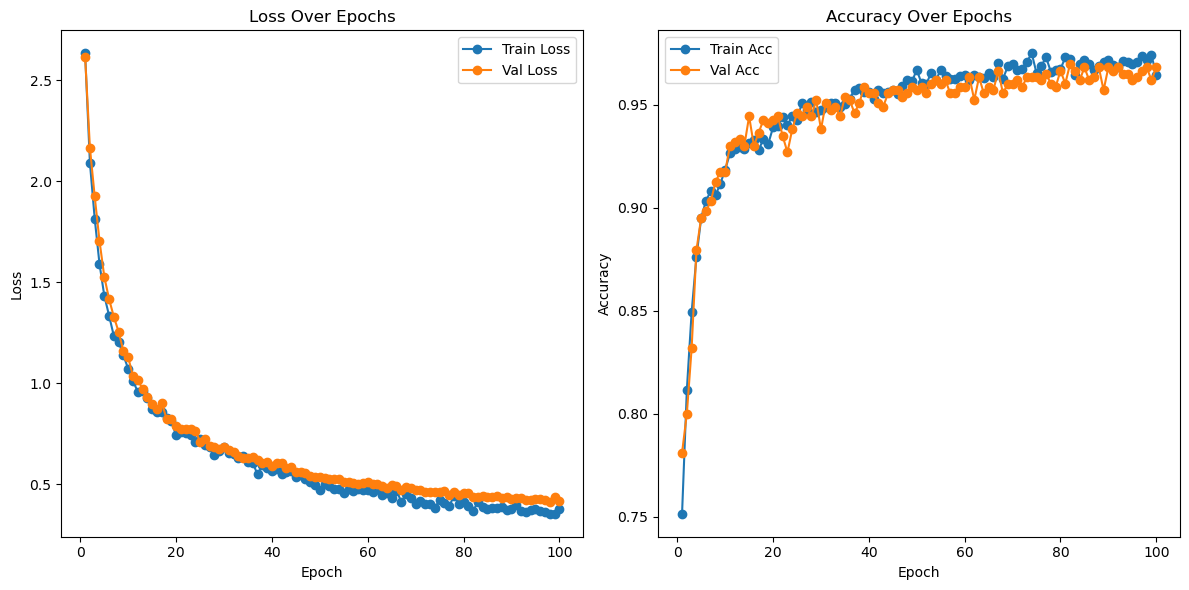

In [8]:
# Plot the train and val losses and accuracies
plot_train_val_losses(len(val_losses), train_losses, train_accuracies, val_losses, val_accuracies)

Validation Accuracy: 0.8730, F1 Score: 0.9364, Precision: 0.9620, Recall: 0.9137
              precision    recall  f1-score   support

      kohaku       1.00      0.97      0.99        35
       sanke       0.92      0.79      0.85        14
       showa       0.93      0.93      0.93        43
      tancho       1.00      1.00      1.00        13
         gin       0.96      0.88      0.92        59

   micro avg       0.96      0.91      0.94       164
   macro avg       0.96      0.91      0.94       164
weighted avg       0.96      0.91      0.94       164
 samples avg       0.93      0.92      0.92       164



/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


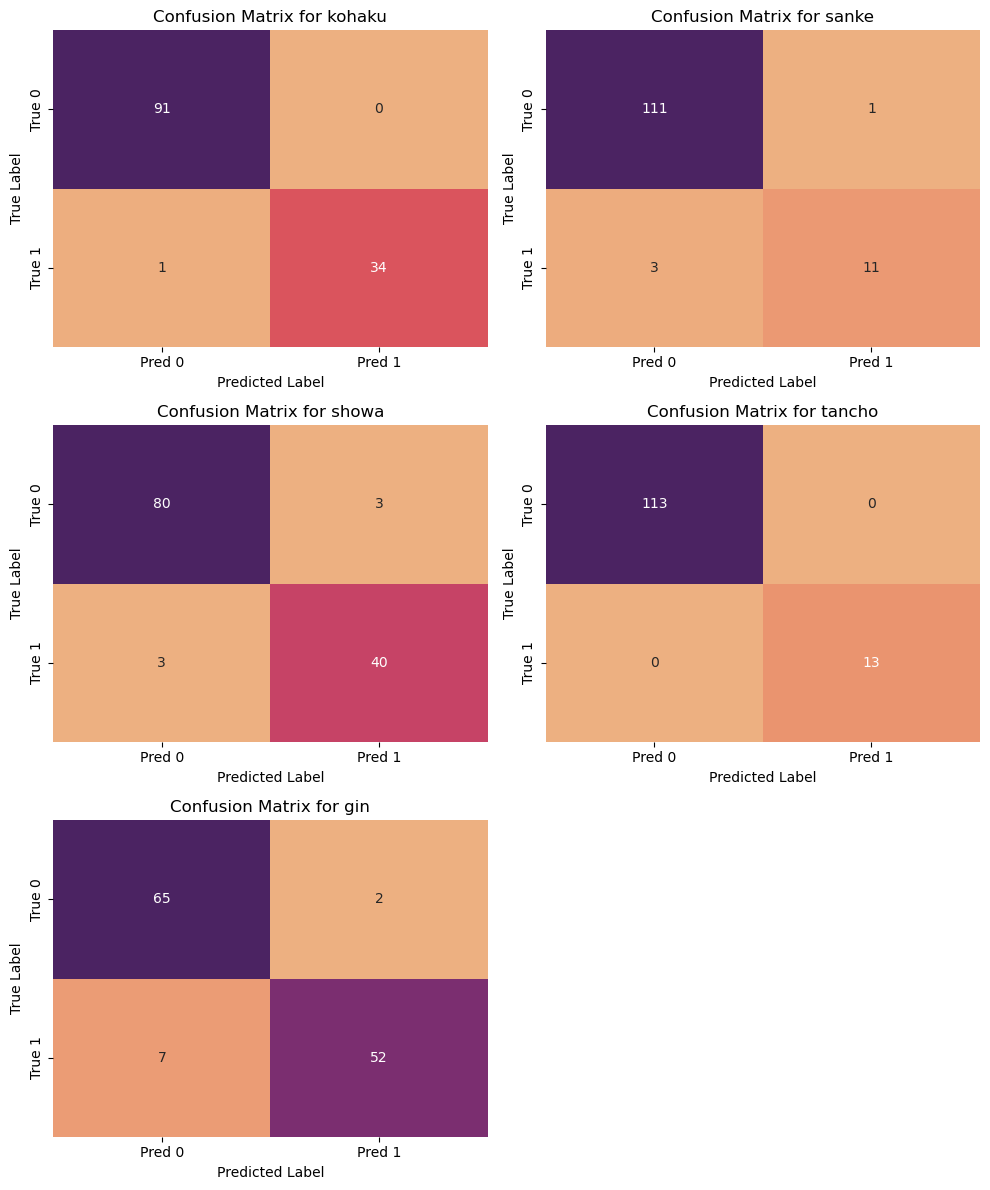

In [9]:
# Evaluate the model
all_preds, all_labels, scores = evaluate_model_flare(model, val_loader, device, class_labels=LABELS)

In [ ]:
# Define the model
model = get_resnet18_model(num_classes)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss(weight=pos_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model,
                                                                         train_loader,
                                                                         val_loader,
                                                                         criterion,
                                                                         optimizer,
                                                                         device,
                                                                         num_epochs=num_epochs)

In [ ]:
# Calculate the class balance
pos_weights = get_class_weights(train_df, device)

# Define the model (with UNFROZEN layers)
model = get_resnet18_model(num_classes)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss(weight=pos_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define a scheduler to implement reducing learning rate on plateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Train the model
num_epochs = 100


train_losses, train_accuracies, val_losses, val_accuracies = train_model_earlystop_reducelronplateau(model,
                                                                                                    train_loader,
                                                                                                    val_loader,
                                                                                                    criterion,
                                                                                                    optimizer,
                                                                                                    device,
                                                                                                    scheduler,
                                                                                                    num_epochs=num_epochs,
                                                                                                    patience=5,
                                                                                                    best_model_name='best_model_frozen_ResNet18.pth')

In [39]:
# Define the model
model = get_resnet18_model(num_classes)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss(weight=pos_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model,
                                                                         train_loader,
                                                                         val_loader,
                                                                         criterion,
                                                                         optimizer,
                                                                         device,
                                                                         num_epochs=num_epochs)

Epoch 1/20 | Train Loss: 1.4772, Train Acc: 87.09% | Val Loss: 3.1334, Val Acc: 87.46%
Epoch 2/20 | Train Loss: 0.7007, Train Acc: 93.98% | Val Loss: 1.2449, Val Acc: 93.02%
Epoch 3/20 | Train Loss: 0.5937, Train Acc: 94.68% | Val Loss: 1.2275, Val Acc: 85.71%
Epoch 4/20 | Train Loss: 0.3475, Train Acc: 96.97% | Val Loss: 1.4898, Val Acc: 88.41%
Epoch 5/20 | Train Loss: 0.2450, Train Acc: 98.04% | Val Loss: 0.5047, Val Acc: 95.40%
Epoch 6/20 | Train Loss: 0.2767, Train Acc: 97.44% | Val Loss: 0.3546, Val Acc: 96.67%
Epoch 7/20 | Train Loss: 0.1633, Train Acc: 98.74% | Val Loss: 0.3844, Val Acc: 96.67%
Epoch 8/20 | Train Loss: 0.1984, Train Acc: 98.50% | Val Loss: 1.0195, Val Acc: 92.54%
Epoch 9/20 | Train Loss: 0.2429, Train Acc: 97.94% | Val Loss: 3.6475, Val Acc: 78.41%
Epoch 10/20 | Train Loss: 0.2558, Train Acc: 98.07% | Val Loss: 1.2805, Val Acc: 91.75%
Epoch 11/20 | Train Loss: 0.2382, Train Acc: 98.04% | Val Loss: 0.4985, Val Acc: 96.51%
Epoch 12/20 | Train Loss: 0.1517, Train A

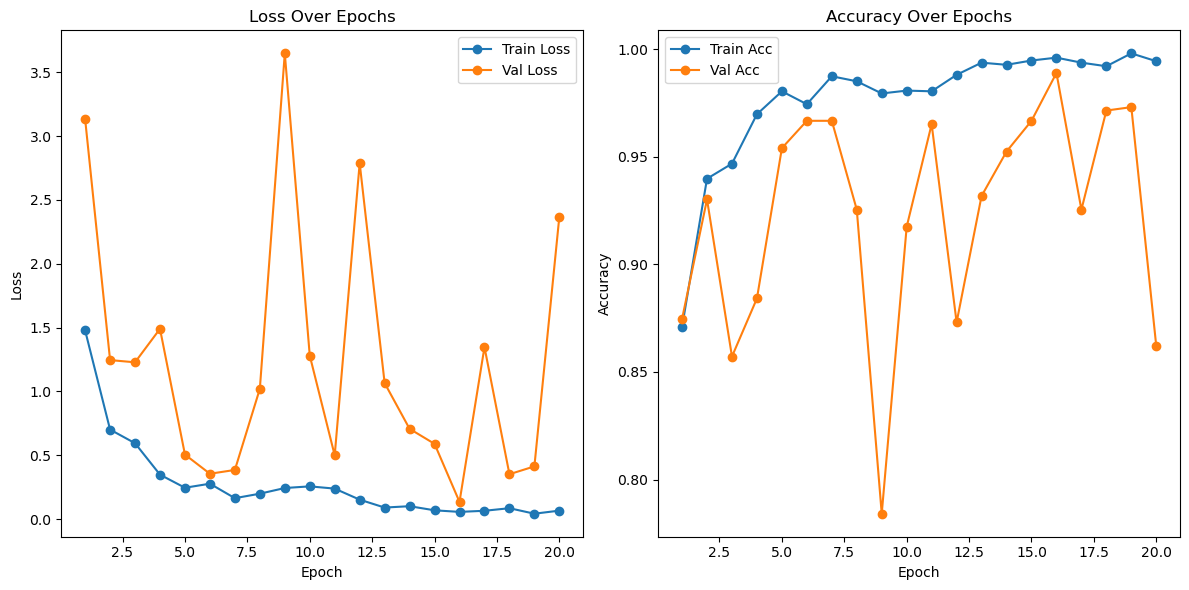

In [40]:
# Plot the train and val losses and accuracies
plot_train_val_losses(num_epochs, train_losses, train_accuracies, val_losses, val_accuracies)

/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Validation Accuracy: 0.5714, F1 Score: 0.6436, Precision: 0.7036, Recall: 0.6509
              precision    recall  f1-score   support

      kohaku       1.00      0.54      0.70        35
       sanke       0.00      0.00      0.00        14
       showa       0.52      1.00      0.68        43
      tancho       1.00      1.00      1.00        13
         gin       1.00      0.71      0.83        59

   micro avg       0.75      0.71      0.73       164
   macro avg       0.70      0.65      0.64       164
weighted avg       0.79      0.71      0.71       164
 samples avg       0.73      0.71      0.70       164



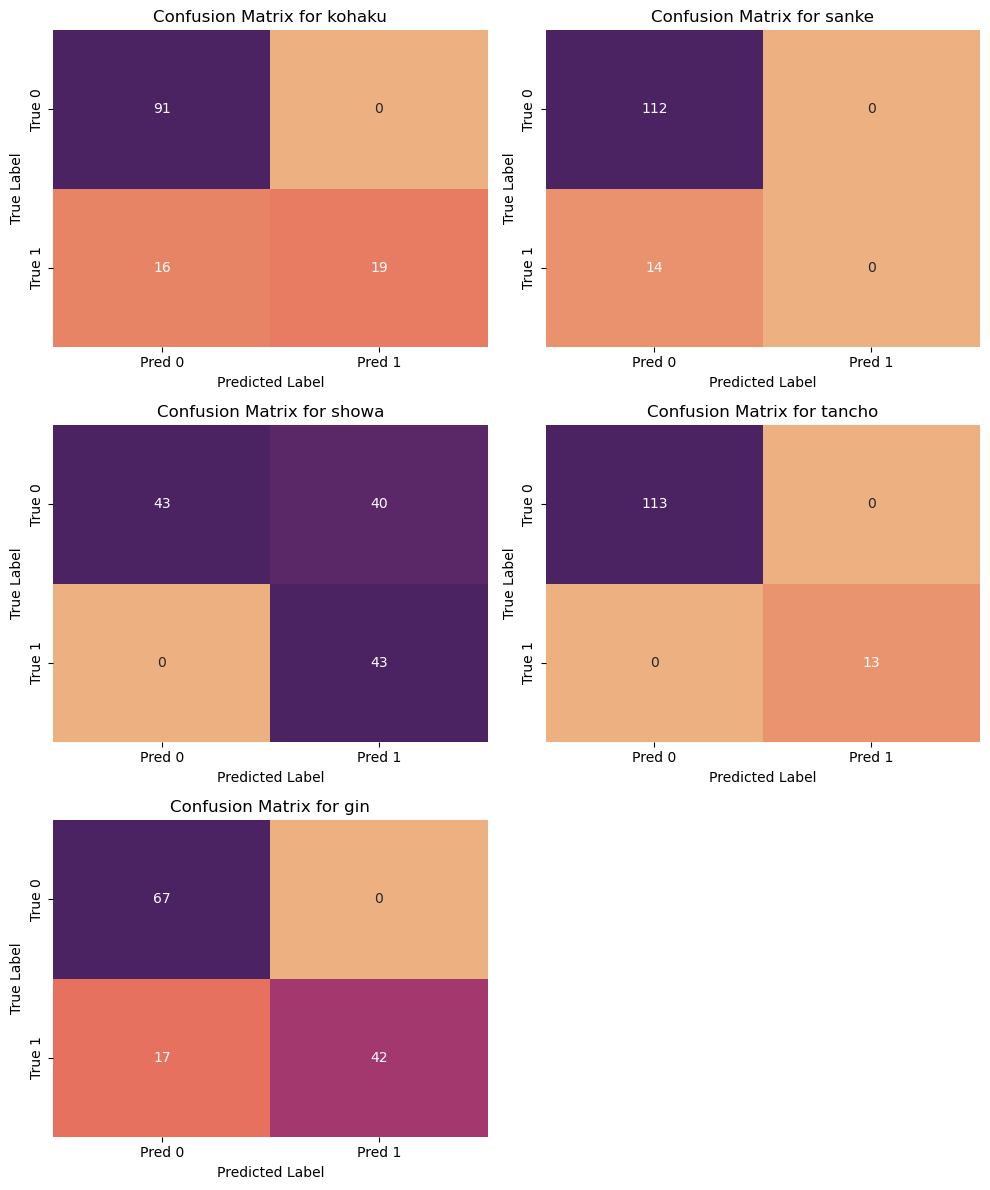

In [41]:
# Evaluate the model
all_preds, all_labels, scores = evaluate_model_flare(model, val_loader, device, class_labels=LABELS)

In [42]:
# Save the model
torch.save(model.state_dict(), 'models/model_resnet18_1_class_balance.pth')

# MODEL 2: Image Augmentation & Reduced Learning Rate

In [43]:
# Define the transform
transform_img_aug = transform_img_aug()
transform = transform_basic()

# Create the datasets
train_ds = CustomMultiLabelDataset(train_df, 'image_path','mhe', dir_path='pictures/', transforms=transform_img_aug)
test_ds = CustomMultiLabelDataset(test_df, 'image_path','mhe', dir_path='pictures/', transforms=transform)
val_ds = CustomMultiLabelDataset(val_df, 'image_path','mhe', dir_path='pictures/', transforms=transform)

# Create data loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

# Check the tensors
tensor_checker(train_loader, test_loader, val_loader)

<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])
<class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
<class 'torch.Tensor'> torch.Size([32, 5])


In [44]:
# Calculate the class balance
pos_weights = get_class_weights(train_df, device)

# Define the model
model = get_resnet18_model(num_classes)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss(weight=pos_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model
num_epochs = 20

train_losses, train_accuracies, val_losses, val_accuracies = train_model(model,
                                                                         train_loader,
                                                                         val_loader,
                                                                         criterion,
                                                                         optimizer,
                                                                         device,
                                                                         num_epochs=num_epochs)

label_counts: [181 165 126  42 191]
total_samples: 601
pos_weights: [ 3.32044199  3.64242424  4.76984127 14.30952381  3.14659686]
Epoch 1/20 | Train Loss: 2.8881, Train Acc: 78.04% | Val Loss: 1.6753, Val Acc: 89.21%
Epoch 2/20 | Train Loss: 1.2096, Train Acc: 94.41% | Val Loss: 0.8961, Val Acc: 93.49%
Epoch 3/20 | Train Loss: 0.7172, Train Acc: 96.51% | Val Loss: 0.6859, Val Acc: 94.76%
Epoch 4/20 | Train Loss: 0.5085, Train Acc: 96.97% | Val Loss: 0.4481, Val Acc: 97.30%
Epoch 5/20 | Train Loss: 0.3879, Train Acc: 98.34% | Val Loss: 0.3372, Val Acc: 97.14%
Epoch 6/20 | Train Loss: 0.3103, Train Acc: 98.70% | Val Loss: 0.3180, Val Acc: 97.78%
Epoch 7/20 | Train Loss: 0.2725, Train Acc: 98.90% | Val Loss: 0.6103, Val Acc: 94.29%
Epoch 8/20 | Train Loss: 0.2401, Train Acc: 99.33% | Val Loss: 0.2123, Val Acc: 98.57%
Epoch 9/20 | Train Loss: 0.2068, Train Acc: 99.23% | Val Loss: 0.3278, Val Acc: 97.14%
Epoch 10/20 | Train Loss: 0.2044, Train Acc: 99.10% | Val Loss: 0.1989, Val Acc: 98.89%

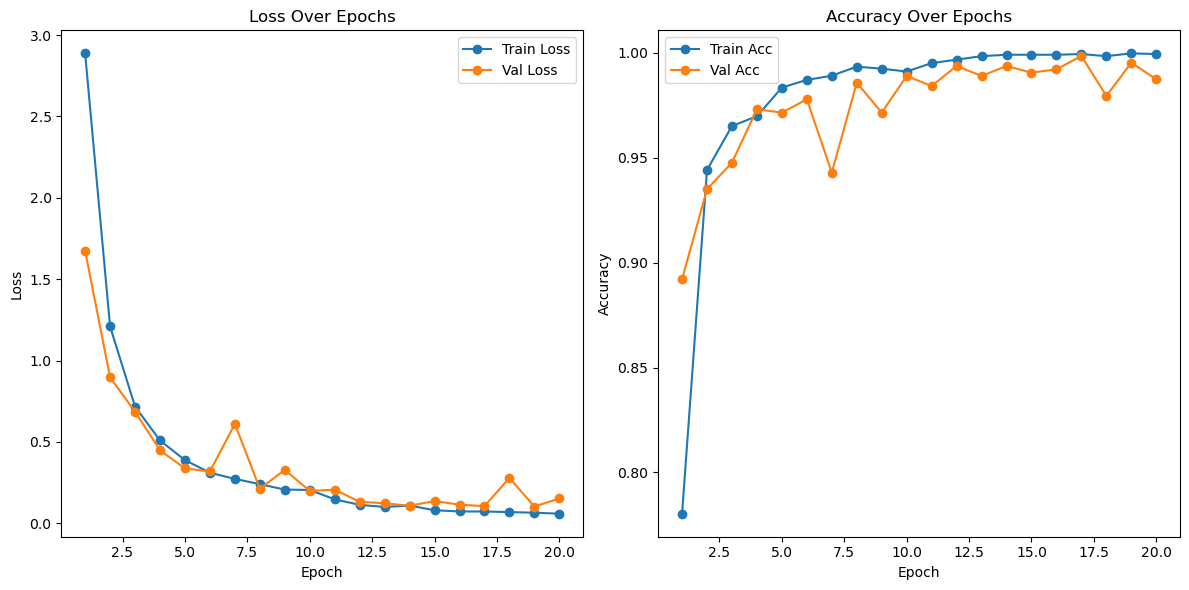

In [45]:
# Plot the train and val losses and accuracies
plot_train_val_losses(num_epochs, train_losses, train_accuracies, val_losses, val_accuracies)

Validation Accuracy: 0.9683, F1 Score: 0.9700, Precision: 0.9647, Recall: 0.9793
              precision    recall  f1-score   support

      kohaku       1.00      1.00      1.00        35
       sanke       0.82      1.00      0.90        14
       showa       1.00      0.93      0.96        43
      tancho       1.00      1.00      1.00        13
         gin       1.00      0.97      0.98        59

   micro avg       0.98      0.97      0.98       164
   macro avg       0.96      0.98      0.97       164
weighted avg       0.98      0.97      0.98       164
 samples avg       0.98      0.98      0.98       164



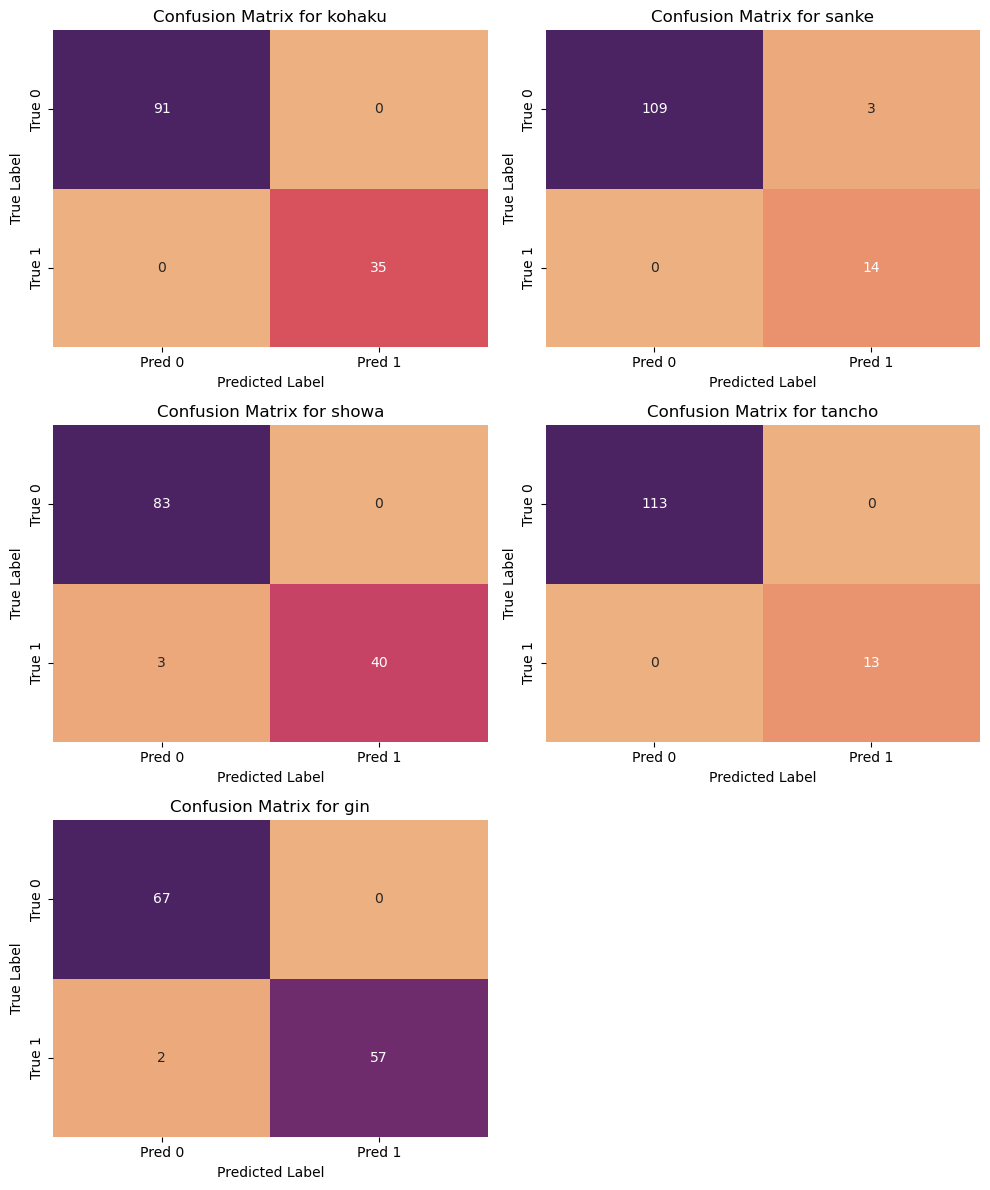

In [46]:
# Evaluate the model
all_preds, all_labels, scores = evaluate_model_flare(model, val_loader, device, class_labels=LABELS)

In [47]:
# Save the model
torch.save(model.state_dict(), 'models/model_resnet18_2_image_augmentation.pth')

# MODEL 3: ReduceLROnPlateau and EarlyStopping

In [48]:
# Calculate the class balance
pos_weights = get_class_weights(train_df, device)

# Define the model
model = get_resnet18_model(num_classes)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss(weight=pos_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Define a scheduler to implement reducing learning rate on plateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Train the model
num_epochs = 20


train_losses, train_accuracies, val_losses, val_accuracies = train_model_earlystop_reducelronplateau(model,
                                                                                                    train_loader,
                                                                                                    val_loader,
                                                                                                    criterion,
                                                                                                    optimizer,
                                                                                                    device,
                                                                                                    scheduler,
                                                                                                    num_epochs=num_epochs,
                                                                                                    patience=3)


label_counts: [181 165 126  42 191]
total_samples: 601
pos_weights: [ 3.32044199  3.64242424  4.76984127 14.30952381  3.14659686]


/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 | Train Loss: 2.7368, Train Acc: 75.04% | Val Loss: 2.0504, Val Acc: 86.98% | LR: 0.000100
Epoch 2/20 | Train Loss: 1.1825, Train Acc: 93.61% | Val Loss: 0.7463, Val Acc: 94.60% | LR: 0.000100
Epoch 3/20 | Train Loss: 0.6826, Train Acc: 96.67% | Val Loss: 0.5380, Val Acc: 96.67% | LR: 0.000100
Epoch 4/20 | Train Loss: 0.4492, Train Acc: 97.90% | Val Loss: 0.4307, Val Acc: 96.98% | LR: 0.000100
Epoch 5/20 | Train Loss: 0.3887, Train Acc: 97.97% | Val Loss: 0.3374, Val Acc: 98.41% | LR: 0.000100
Epoch 6/20 | Train Loss: 0.2612, Train Acc: 99.23% | Val Loss: 0.2861, Val Acc: 98.41% | LR: 0.000100
Epoch 7/20 | Train Loss: 0.2385, Train Acc: 98.90% | Val Loss: 0.2872, Val Acc: 97.46% | LR: 0.000100
Epoch 8/20 | Train Loss: 0.1757, Train Acc: 99.50% | Val Loss: 0.1985, Val Acc: 99.21% | LR: 0.000100
Epoch 9/20 | Train Loss: 0.1564, Train Acc: 99.87% | Val Loss: 0.1934, Val Acc: 99.05% | LR: 0.000100
Epoch 10/20 | Train Loss: 0.1289, Train Acc: 99.83% | Val Loss: 0.2768, Val Acc: 9

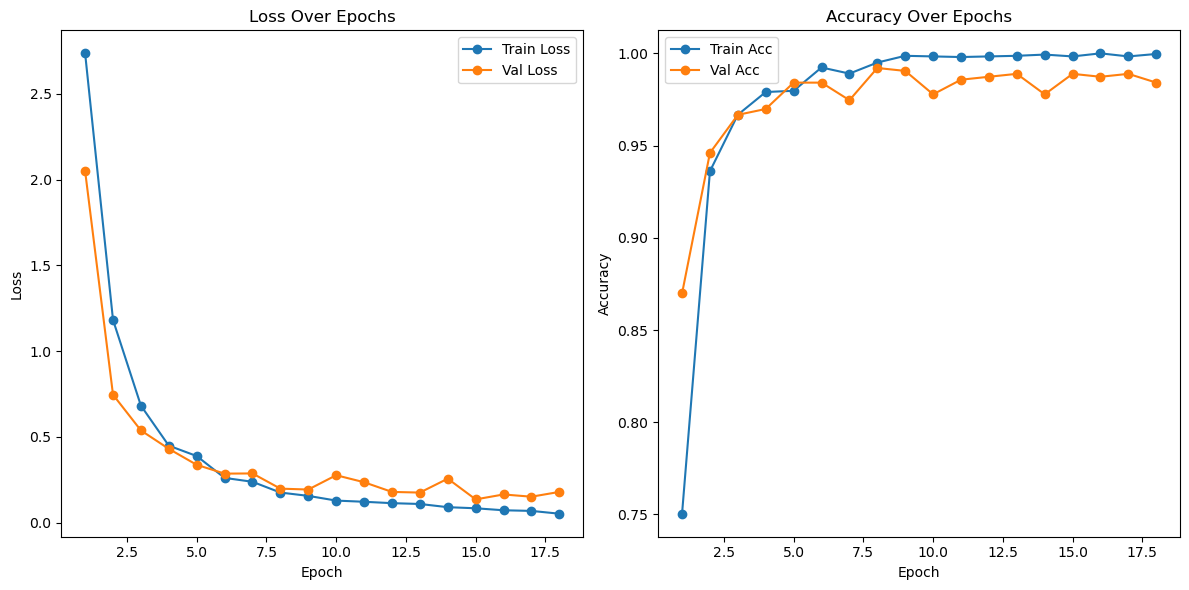

In [49]:
# Plot the train and val losses and accuracies
plot_train_val_losses(len(val_losses), train_losses, train_accuracies, val_losses, val_accuracies)

Validation Accuracy: 0.9524, F1 Score: 0.9609, Precision: 0.9556, Recall: 0.9734
              precision    recall  f1-score   support

      kohaku       1.00      1.00      1.00        35
       sanke       0.78      1.00      0.88        14
       showa       1.00      0.88      0.94        43
      tancho       1.00      1.00      1.00        13
         gin       1.00      0.98      0.99        59

   micro avg       0.98      0.96      0.97       164
   macro avg       0.96      0.97      0.96       164
weighted avg       0.98      0.96      0.97       164
 samples avg       0.97      0.96      0.97       164



/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


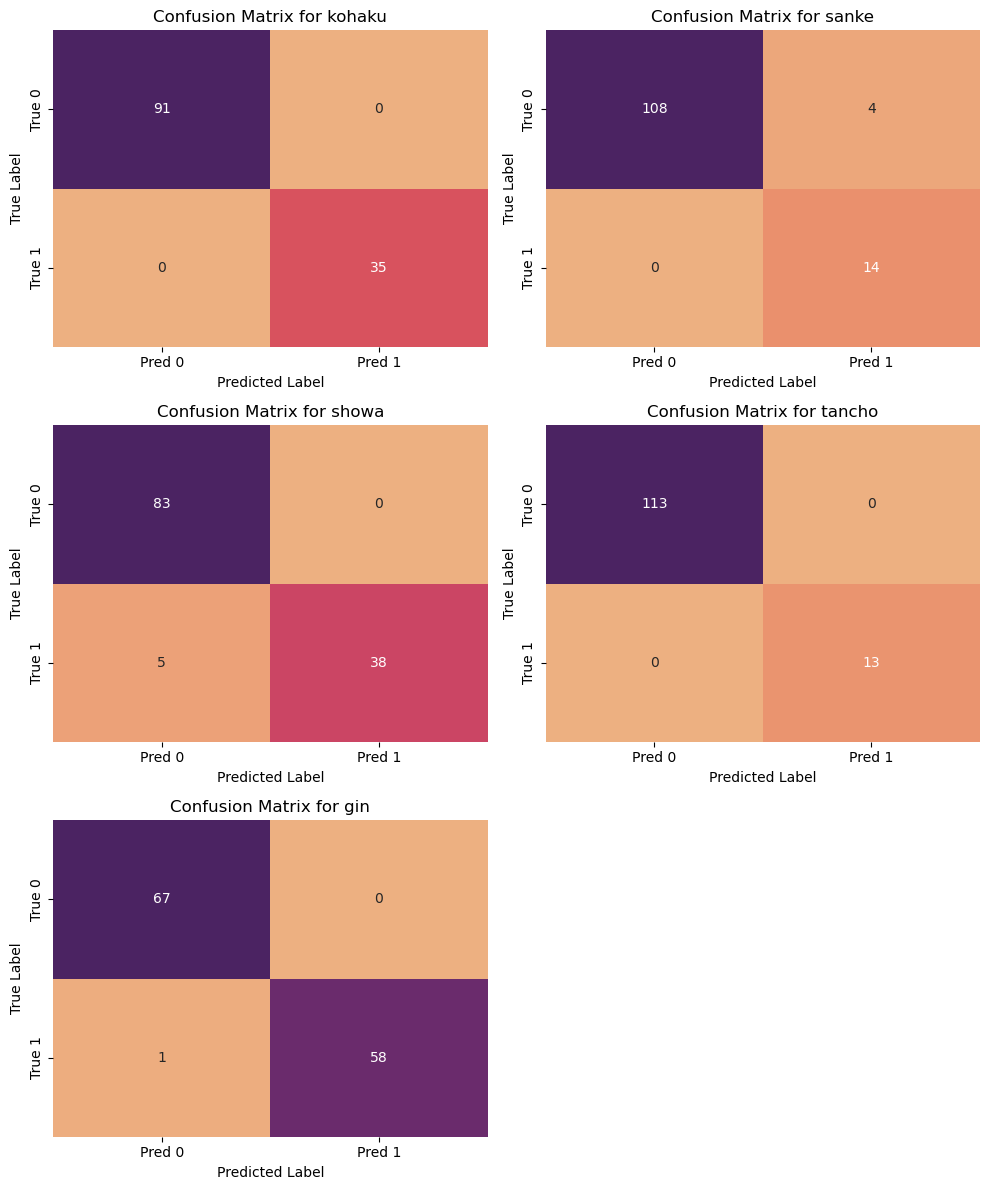

In [50]:
# Evaluate the model
all_preds, all_labels, scores = evaluate_model_flare(model, val_loader, device, class_labels=LABELS)

In [51]:
# Save the model
torch.save(model.state_dict(), 'models/model_resnet18_3_reducelronplateau_earlystopping.pth')

# MODEL 4: Freeze ResNet18 Layers

In [52]:
# Calculate the class balance
pos_weights = get_class_weights(train_df, device)

# Define the model (with FROZEN layers)
model = get_resnet18_model_frozen(num_classes)

# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss(weight=pos_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define a scheduler to implement reducing learning rate on plateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Train the model
num_epochs = 100


train_losses, train_accuracies, val_losses, val_accuracies = train_model_earlystop_reducelronplateau(model,
                                                                                                    train_loader,
                                                                                                    val_loader,
                                                                                                    criterion,
                                                                                                    optimizer,
                                                                                                    device,
                                                                                                    scheduler,
                                                                                                    num_epochs=num_epochs,
                                                                                                    patience=5)


label_counts: [181 165 126  42 191]
total_samples: 601
pos_weights: [ 3.32044199  3.64242424  4.76984127 14.30952381  3.14659686]
Epoch 1/100 | Train Loss: 2.6994, Train Acc: 73.44% | Val Loss: 2.7802, Val Acc: 75.08% | LR: 0.001000
Epoch 2/100 | Train Loss: 2.1737, Train Acc: 80.00% | Val Loss: 2.2355, Val Acc: 78.89% | LR: 0.001000
Epoch 3/100 | Train Loss: 1.8599, Train Acc: 82.66% | Val Loss: 1.9576, Val Acc: 82.38% | LR: 0.001000
Epoch 4/100 | Train Loss: 1.6688, Train Acc: 85.89% | Val Loss: 1.7303, Val Acc: 83.65% | LR: 0.001000
Epoch 5/100 | Train Loss: 1.4899, Train Acc: 87.69% | Val Loss: 1.5656, Val Acc: 87.46% | LR: 0.001000
Epoch 6/100 | Train Loss: 1.3973, Train Acc: 88.09% | Val Loss: 1.4134, Val Acc: 89.37% | LR: 0.001000
Epoch 7/100 | Train Loss: 1.2770, Train Acc: 90.75% | Val Loss: 1.3399, Val Acc: 88.25% | LR: 0.001000
Epoch 8/100 | Train Loss: 1.2414, Train Acc: 90.35% | Val Loss: 1.2554, Val Acc: 90.16% | LR: 0.001000
Epoch 9/100 | Train Loss: 1.1880, Train Acc: 9

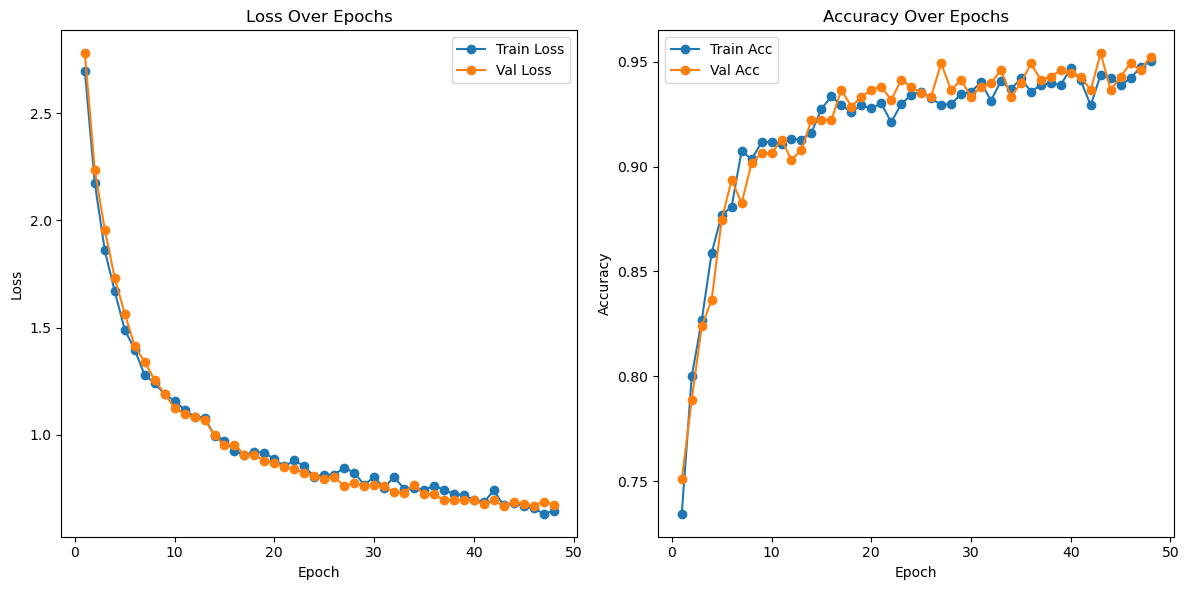

In [53]:
# Plot the train and val losses and accuracies
plot_train_val_losses(len(val_losses), train_losses, train_accuracies, val_losses, val_accuracies)

Validation Accuracy: 0.7937, F1 Score: 0.8983, Precision: 0.9594, Recall: 0.8550
              precision    recall  f1-score   support

      kohaku       1.00      0.91      0.96        35
       sanke       1.00      0.64      0.78        14
       showa       0.87      0.93      0.90        43
      tancho       1.00      0.92      0.96        13
         gin       0.93      0.86      0.89        59

   micro avg       0.94      0.88      0.91       164
   macro avg       0.96      0.85      0.90       164
weighted avg       0.94      0.88      0.90       164
 samples avg       0.90      0.89      0.89       164



/Users/annahan/miniforge3/envs/pytorch-1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


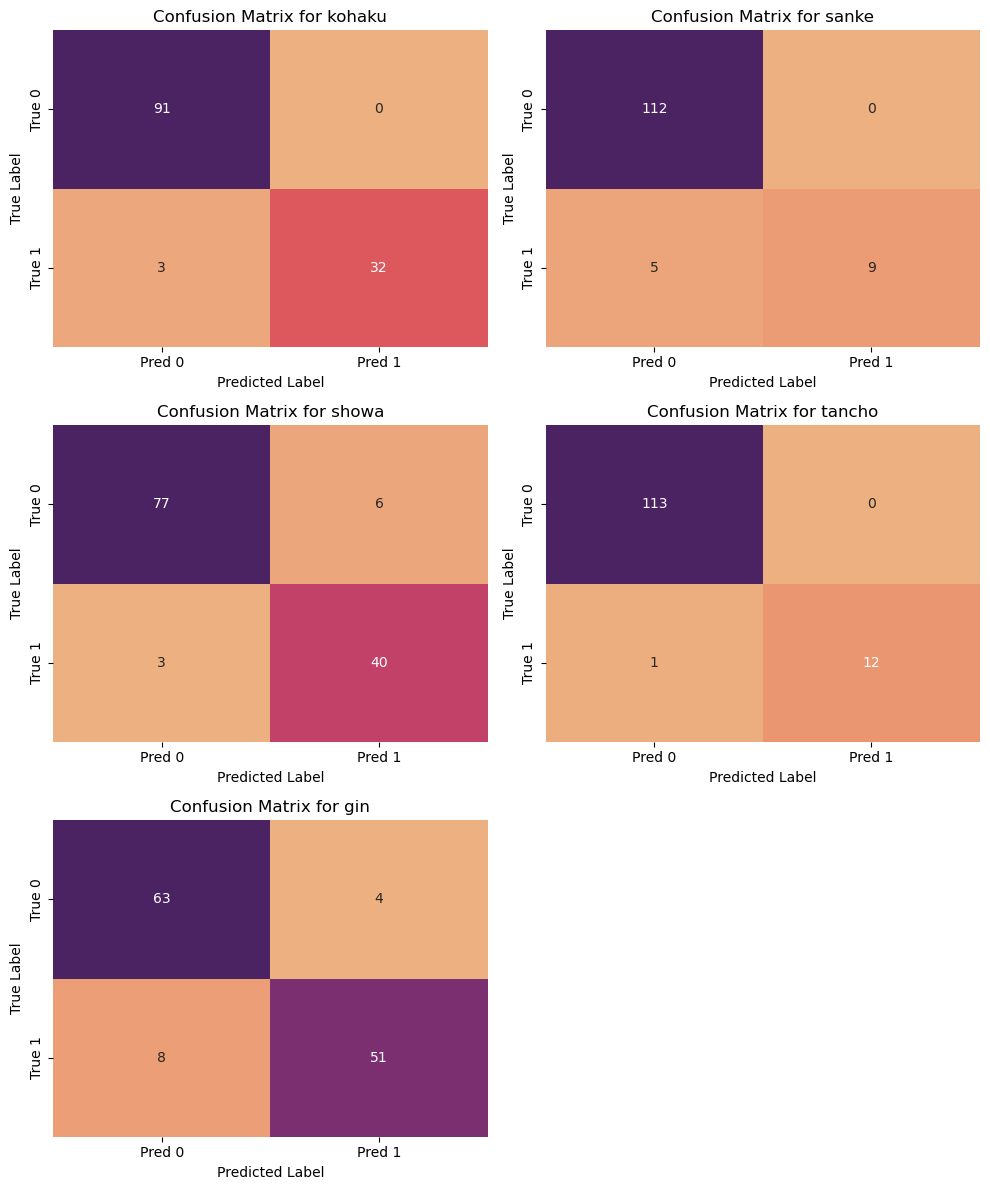

In [54]:
# Evaluate the model
all_preds, all_labels, scores = evaluate_model_flare(model, val_loader, device, class_labels=LABELS)

In [55]:
# Save the model
torch.save(model.state_dict(), 'models/model_resnet18_4_frozen_layers.pth')